# Flood segmentation

Using a Kaggle dataset: [ETCi 2021 Competition on Flood Detection](https://www.kaggle.com/datasets/aninda/etci-2021-competition-on-flood-detection) ([NASA contest](https://nasa-impact.github.io/etci2021/))

* Objective: delineate open water flood areas as an effort to identify flood extent.
* Data: synthetic aperture radar (SAR) images.

SAR imagery: signal is based on surface characteristics like structure and moisture (https://earthdata.nasa.gov/learn/backgrounders/what-is-sar). SAR sensors transmit linearly polarized: 
* Horizontal polarization = H
* Vertical polarization = V.

## Evaluation

Performance official evaluation: evaluated using the intersection over union (IOU) score = Jaccard score.

In [1]:
from IPython.display import Image
Image(url="https://929687.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=1&strip=1&webp=1", width=300)

## Setup

### Import necessary modules and do some basic setup.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import glob
import numpy as np
from pathlib import Path
from tqdm.notebook import trange, tqdm

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Pytorch and other stuff
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch.functional import F
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import skimage.io
from torchinfo import summary
from torchvision import transforms
import torchmetrics

In [3]:
# Paths
DATAPATH = Path("../SAR-Flood-Segmentation")

In [4]:
# Options
BATCH_SIZE = 32
TEST_MODE = False
USE_GPU = True

### Helper functions

In [5]:
def show_images(**images):
    """Show the provided images in a single row."""
    n_rows = len(images)
    plt.figure(figsize=(18, 6))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_rows, i + 1)
        plt.axis('off')
        plt.title(' '.join(name.split('_')))
        plt.imshow(image)
    plt.show()


def show_train_event(event, tile):
    """Show the tiles for a given event in the train period."""
    flood_label = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "flood_label" / f"{event}_{tile}.png")
    water_body_label = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "water_body_label" / f"{event}_{tile}.png")
    vv = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "vv" / f"{event}_{tile}_vv.png")
    vh = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "vh" / f"{event}_{tile}_vh.png")

    show_images(vv=vv, vh=vh, water_body_label=water_body_label, flood_label=flood_label)


def get_image_paths(base_dir, limit_files_nb=False):
    """Get the paths of the images and label in a consistant way."""
    vh_files = sorted(list(base_dir.glob('**/vh/*.png')))
    vv_files = sorted(list(base_dir.glob('**/vv/*.png')))
    if limit_files_nb:
        vh_files = vh_files[0:5000]
        vv_files = vv_files[0:5000]
    # Need to handle the label files differently as the sorted() function returns another order.
    label_files = [Path(str(x).replace('tiles/vh', 'tiles/flood_label')
                              .replace('tiles\\vh', 'tiles\\flood_label')
                              .replace('_vh', '')) for x in vh_files]
    
    return [vh_files, vv_files, label_files]


## Data

Tiles of 256×256 pixels:
* training: 33,405 (33,405 x 2 VV & VH polarization)
* validation: 10,400
* test: 12,348 tiles -> no label

Sentinel-1 C-band synthetic aperture radar (SAR) imagery. VV & VH polarizations available
* VV = Signals emitted in vertical (V) and received in vertical (V) polarization 
* VH = Signals emitted in vertical (V) and received in horizontal (H) polarization

Signal strength from these different polarizations (https://earthdata.nasa.gov/learn/backgrounders/what-is-sar):
* Rough surface scattering, such as that caused by bare soil or water, is most sensitive to VV scattering.
* Volume scattering, for example, caused by the leaves and branches in a forest canopy, is most sensitive to cross-polarized data like VH or HV.

29 different flood events in 5 different regions. 4 sub-folders: vv, vh, flood_label and water_body_label


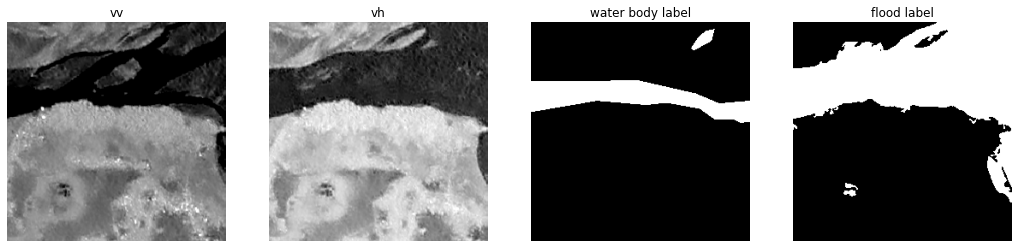

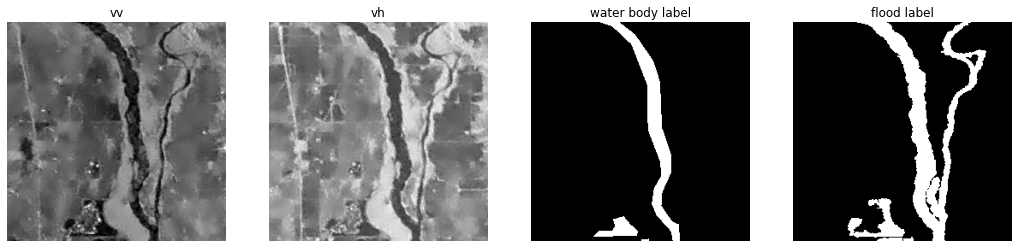

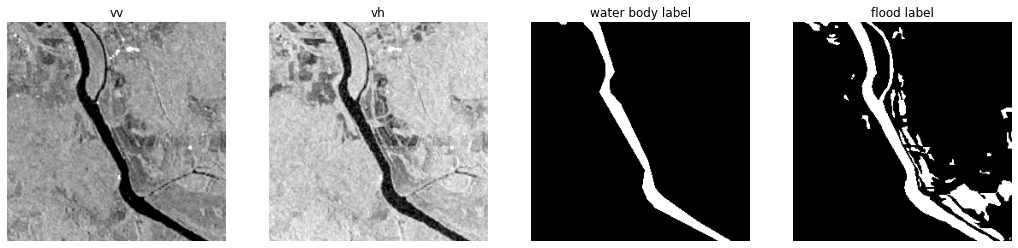

In [6]:
show_train_event(event="bangladesh_20170314t115609", tile="x-5_y-33")
show_train_event(event="nebraska_20170508t002113", tile="x-5_y-20")
show_train_event(event="northal_20190618t234654", tile="x-14_y-22")

### File lists

In [7]:
# Get lists of files
[train_valid_vh_files, train_valid_vv_files, train_valid_label_files] = get_image_paths(DATAPATH / "train", limit_files_nb=TEST_MODE)
[test_vh_files, test_vv_files, test_label_files] = get_image_paths(DATAPATH / "val_with_ref_labels", limit_files_nb=TEST_MODE)

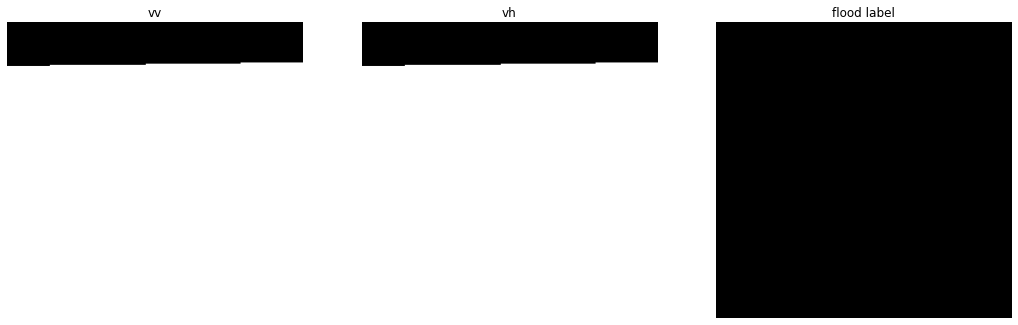

In [8]:
# Some files at the border are empty...
idx = 1
show_images(vv=skimage.io.imread(train_valid_vv_files[idx]), 
            vh=skimage.io.imread(train_valid_vh_files[idx]), 
            flood_label=skimage.io.imread(train_valid_label_files[idx]))

In [9]:
# ... and only have the values 0 or 255
img = skimage.io.imread(train_valid_vv_files[idx])
(img[img < 255] > 0).any()

False

In [10]:
# Drop these empty files and the files with no floods
def filter_images(vv_files, vh_files, label_files):
    counter_empty = 0
    counter_no_floods = 0
    counter_ok = 0

    n_iter = len(vv_files)
    pbar = tqdm(range(n_iter))

    for i, path in reversed(list(enumerate(vv_files))):

        pbar.update(1)
        pbar.refresh()

        # Drop if empty
        image = skimage.io.imread(path)
        if not (image[image < 255] > 0).any():
            del vv_files[i]
            del vh_files[i]
            del label_files[i]
            counter_empty += 1
            continue

        # Drop if no flood
        label = skimage.io.imread(label_files[i])
        if not (label[:,:,0] > 0).any():
            del vv_files[i]
            del vh_files[i]
            del label_files[i]
            counter_no_floods += 1
            continue

        counter_ok += 1

    print(f"Empty images: {counter_empty}")
    print(f"No flood: {counter_no_floods}")
    print(f"OK images: {counter_ok}")

filter_images(train_valid_vv_files, train_valid_vh_files, train_valid_label_files)
filter_images(test_vv_files, test_vh_files, test_label_files)
    

  0%|          | 0/33405 [00:00<?, ?it/s]

Empty images: 8381
No flood: 14726
OK images: 10298


  0%|          | 0/10400 [00:00<?, ?it/s]

Empty images: 3013
No flood: 4277
OK images: 3110


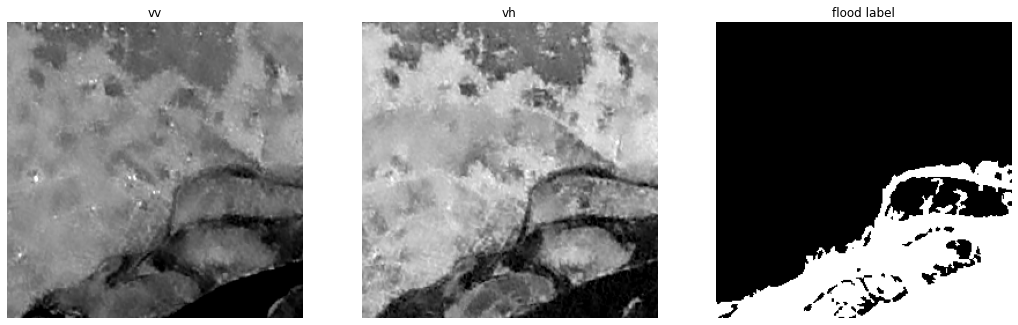

In [11]:
# Show better example file
idx = 500

input_vv = skimage.io.imread(train_valid_vv_files[idx])
input_vh = skimage.io.imread(train_valid_vh_files[idx])
flood_label = skimage.io.imread(train_valid_label_files[idx])

show_images(vv=input_vv, 
            vh=input_vh, 
            flood_label=flood_label)

In [12]:
# Check data types
input_vv.dtype

dtype('uint8')

In [13]:
# Check value range
input_vv.max()

255

In [14]:
# Check label type
flood_label.dtype

dtype('uint8')

In [15]:
flood_label.max()

255

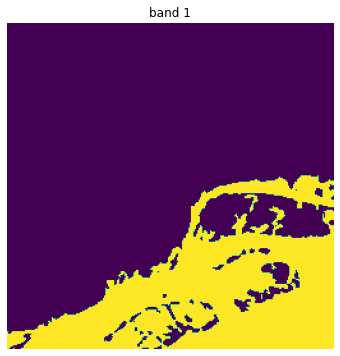

In [16]:
# Transform the mask
flood_label = flood_label[:,:,0]
flood_label[flood_label>0] = 1

show_images(band_1=flood_label)

## Dataset

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

class Floods(Dataset):
    def __init__(self, vh_paths, vv_paths, label_paths, transform=transform):
        super(Floods, self).__init__()
        
        self.vh_paths = vh_paths
        self.vv_paths = vv_paths
        self.label_paths = label_paths
        
        self.transform = transform
        
    def __getitem__(self, index):
        
        # Load both images
        vh = skimage.io.imread(self.vh_paths[index]).astype(np.uint8)
        vv = skimage.io.imread(self.vv_paths[index]).astype(np.uint8)
        
        if self.transform is not None:
            vh = self.transform(vh)
            vv = self.transform(vv)
        else:
            vh = torch.tensor(vh/255, dtype=torch.float32)
            vv = torch.tensor(vv/255, dtype=torch.float32)
        
        # Combine the bands into 6-bands images
        x = torch.cat((vh, vv), 0)

        # Load lables
        y = skimage.io.imread(self.label_paths[index])
        
        # Onky keep one channel for the label
        y = y[:,:,0]
        y[y > 0] = 1
        
        y = torch.tensor(y, dtype=torch.int64)
        y = torch.unsqueeze(y, dim=0)

        return x, y

    def __len__(self):

        return len(self.vh_paths)

In [18]:
# Get datasets
train_valid_data = Floods(train_valid_vh_files, train_valid_vv_files, train_valid_label_files)

train_size = int(0.8 * len(train_valid_data))
valid_size = len(train_valid_data) - train_size

train_data, valid_data = random_split(train_valid_data, [train_size, valid_size])
test_data = Floods(test_vh_files, test_vv_files, test_label_files)

In [ ]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [20]:
# Check shapes
test_image, test_label = next(iter(train_loader))
print(f"Input image size: {test_image.shape}")
print(f"Output size: {test_label.shape}")

Input image size: torch.Size([32, 6, 256, 256])
Output size: torch.Size([32, 1, 256, 256])


In [21]:
test_image.dtype

torch.float32

In [22]:
test_label.dtype

torch.int64

## Unet with flexible architecture

In [23]:
class Unet(pl.LightningModule):
    def __init__(self, classes_nb, learning_rate, depth=4, convs_nb=2, base_channels_nb=64, conv_kernel_size=3, conv_padding=1, pool_kernel_size=2):
        super(Unet, self).__init__()

        self.depth = depth
        self.convs_nb = convs_nb
        self.base_channels_nb = base_channels_nb
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size

        # Lists that are Lightning-compatible
        self.encoder_convs = nn.ModuleList()
        self.encoder_maxpools = nn.ModuleList()
        self.bneck_convs = nn.ModuleList()
        self.decoder_deconvs = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()

        # Encoder
        self.build_encoder()

        # Bottleneck
        self.build_bottleneck()

        # Decoder
        self.build_decoder()
        
        # Last convolution layer
        self.conv_final = nn.Conv2d(in_channels=self.base_channels_nb, out_channels=classes_nb, kernel_size=1)
        
        # Loss function, Jaccard index and learning rate
        self.train_loss = nn.BCELoss()
        self.valid_score = torchmetrics.JaccardIndex(num_classes=classes_nb if classes_nb>1 else 2)
        self.learning_rate = learning_rate
        
    def build_encoder(self):
        for i_depth in range(self.depth):
            in_channels = self.base_channels_nb * 2**(i_depth - 1)
            out_channels = in_channels * 2

            if i_depth == 0:
                in_channels = 6
                out_channels = self.base_channels_nb

            self.encoder_convs.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                                kernel_size=self.conv_kernel_size, padding=self.conv_padding))

            for _ in range(self.convs_nb-1):
                self.encoder_convs.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                                    kernel_size=self.conv_kernel_size, padding=self.conv_padding))

            self.encoder_maxpools.append(nn.MaxPool2d(kernel_size=self.pool_kernel_size))
            
    def build_bottleneck(self):
        bneck_channels_in = self.base_channels_nb * 2**(self.depth - 1)
        bneck_channels = self.base_channels_nb * 2**self.depth
        self.bneck_convs.append(nn.Conv2d(in_channels=bneck_channels_in, out_channels=bneck_channels, 
                                          kernel_size=self.conv_kernel_size, padding=self.conv_padding))
        for _ in range(self.convs_nb-1):
            self.bneck_convs.append(nn.Conv2d(in_channels=bneck_channels, out_channels=bneck_channels, 
                                              kernel_size=self.conv_kernel_size, padding=self.conv_padding))

    def build_decoder(self):
        for i_depth in reversed(range(self.depth)):
            out_channels = self.base_channels_nb * 2**i_depth
            in_channels = out_channels * 2

            self.decoder_deconvs.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                                                           kernel_size=2, padding=0, stride=2))

            # Higher number of channels due to skip connection
            self.decoder_convs.append(nn.Conv2d(in_channels=2*out_channels, out_channels=out_channels, 
                                                kernel_size=self.conv_kernel_size, padding=self.conv_padding))

            for _ in range(self.convs_nb-1):
                self.decoder_convs.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, 
                                                    kernel_size=self.conv_kernel_size, padding=self.conv_padding))

    def forward(self, x):

        skip = []

        # Encoder
        i_conv = 0
        for i_depth in range(self.depth):
            x = F.relu(self.encoder_convs[i_conv](x))
            i_conv += 1
            for _ in range(self.convs_nb-1):
                x = F.relu(self.encoder_convs[i_conv](x))
                i_conv += 1
            skip.append(x)
            x = self.encoder_maxpools[i_depth](x)

        # Bottleneck
        i_conv = 0
        for _ in range(self.convs_nb):
            x = F.relu(self.bneck_convs[i_conv](x))
            i_conv += 1

        # Decoder
        i_conv = 0
        i_deconv = 0
        for i_depth in reversed(range(self.depth)):
            x = self.decoder_deconvs[i_deconv](x)
            i_deconv += 1
            x = torch.cat([x, skip[i_depth]], dim=1)
            x = F.relu(self.decoder_convs[i_conv](x))
            i_conv += 1
            for _ in range(self.convs_nb-1):
                x = F.relu(self.decoder_convs[i_conv](x))
                i_conv += 1

        x = self.conv_final(x)
        
        x = torch.sigmoid(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        preds = self(x)
        loss = self.train_loss(preds, y.type(torch.float32))
        
        self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        preds = self(x)
        loss = self.train_loss(preds, y.type(torch.float32))
        score = self.valid_score(preds, y)
        
        self.log("Loss/Valid", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Jaccard/Valid", score, on_epoch=True, prog_bar=True, logger=True)

        return score
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        

## Training

In [24]:
# Options
EPOCHS = 10

In [25]:
# Configurations to assess
models = {
          'Exp01_1_2_64': {'depth': 1, 'convs_nb': 2, 'base_channels_nb': 64},
          'Exp02_2_2_64': {'depth': 2, 'convs_nb': 2, 'base_channels_nb': 64},
          'Exp03_3_2_64': {'depth': 3, 'convs_nb': 2, 'base_channels_nb': 64},
          'Exp04_4_2_64': {'depth': 4, 'convs_nb': 2, 'base_channels_nb': 64},
          'Exp05_4_1_64': {'depth': 4, 'convs_nb': 1, 'base_channels_nb': 64},
          'Exp07_4_2_32': {'depth': 4, 'convs_nb': 2, 'base_channels_nb': 32},
          'Exp08_4_2_16': {'depth': 4, 'convs_nb': 2, 'base_channels_nb': 16},
         }

In [26]:
save_path = Path('./saved_models')

for m_id in models:
    filename = m_id + '.pt'
    
    if os.path.exists(save_path / filename):
        continue
    
    depth = models[m_id]['depth']
    convs_nb = models[m_id]['convs_nb']
    base_channels_nb = models[m_id]['base_channels_nb']
    
    print(f"Running {m_id}: depth={depth}, convs_nb={convs_nb}, base_channels_nb={base_channels_nb}")
    
    unet = Unet(classes_nb=1, learning_rate=1e-3, depth=depth, convs_nb=convs_nb, base_channels_nb=base_channels_nb)
    
    logger = TensorBoardLogger("tb_logs", name="ml_floods")

    if USE_GPU:
        trainer = pl.Trainer(max_epochs=EPOCHS, logger=logger, accelerator='gpu', strategy='dp', devices=1)
        # summary(unet, input_size=(BATCH_SIZE, 6, 256, 256), device = 'cuda')
    else:
        trainer = pl.Trainer(max_epochs=EPOCHS, logger=logger, accelerator='cpu')
        # summary(unet, input_size=(BATCH_SIZE, 6, 256, 256), device = 'cpu')
        
    trainer.fit(unet, train_dataloaders=train_loader, val_dataloaders=validation_loader)

    if not os.path.isdir(save_path):
        os.makedirs(save_path)
        
    torch.save(unet.state_dict(), save_path / filename)

## Displaying outputs

In [27]:
# Get some test data
val_iter = iter(test_loader)
test_batch, test_label = next(val_iter)

Prediction for Exp01_1_2_64 (depth=1, convs_nb=2, base_channels_nb=64)


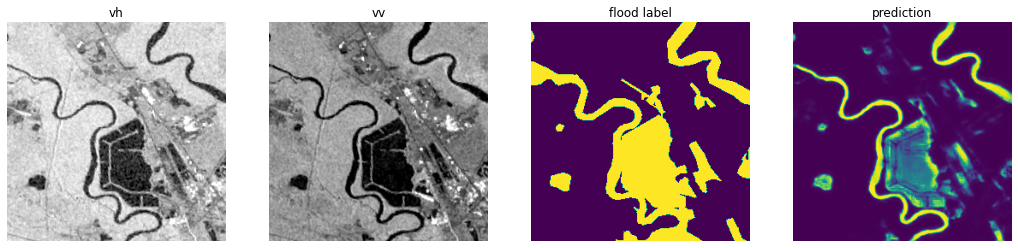

Prediction for Exp02_2_2_64 (depth=2, convs_nb=2, base_channels_nb=64)


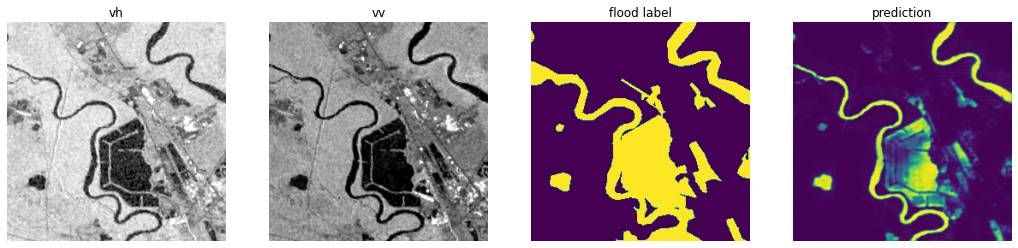

Prediction for Exp03_3_2_64 (depth=3, convs_nb=2, base_channels_nb=64)


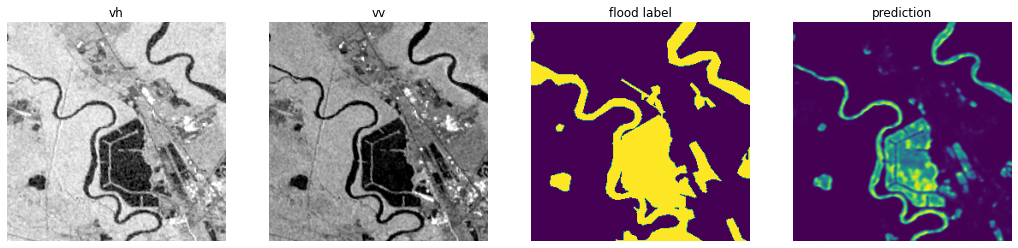

Prediction for Exp04_4_2_64 (depth=4, convs_nb=2, base_channels_nb=64)


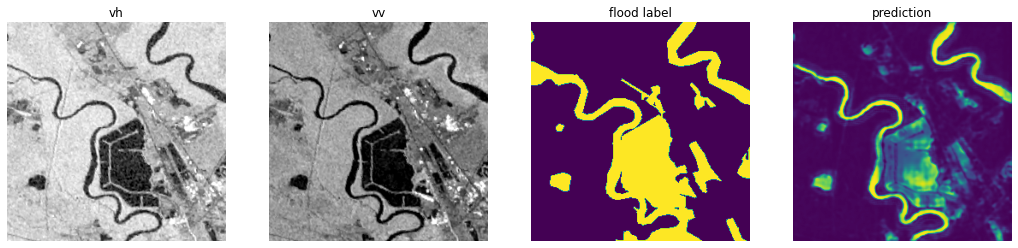

Prediction for Exp05_4_1_64 (depth=4, convs_nb=1, base_channels_nb=64)


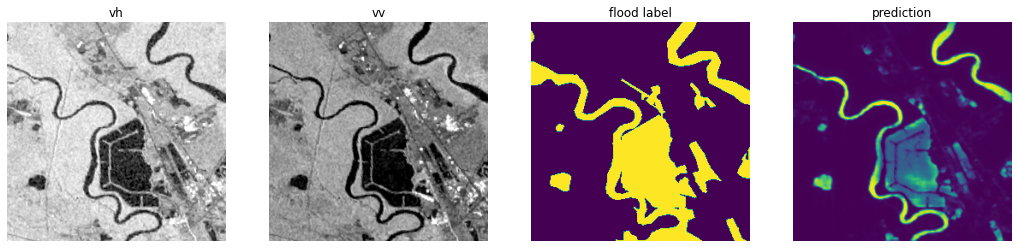

Prediction for Exp07_4_2_32 (depth=4, convs_nb=2, base_channels_nb=32)


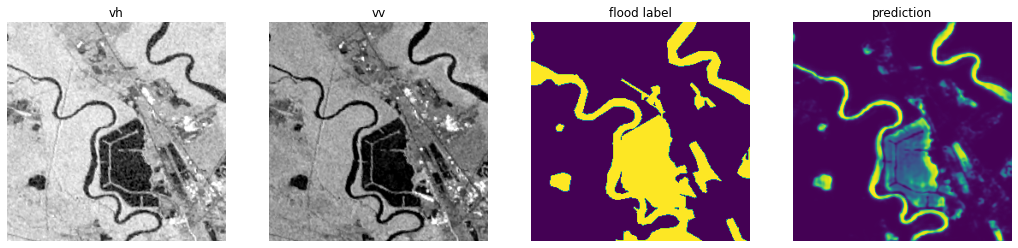

Prediction for Exp08_4_2_16 (depth=4, convs_nb=2, base_channels_nb=16)


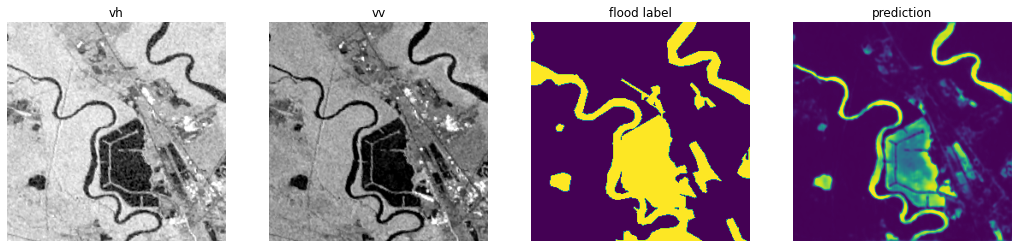

In [28]:
state_path = Path('./saved_models')
idx = 25

for m_id in models:
    filename = m_id + '.pt'
    
    if not os.path.exists(state_path / filename):
        continue
        
    depth = models[m_id]['depth']
    convs_nb = models[m_id]['convs_nb']
    base_channels_nb = models[m_id]['base_channels_nb']
    
    unet = Unet(classes_nb=1, learning_rate=1e-3, depth=depth, convs_nb=convs_nb, base_channels_nb=base_channels_nb)    
    unet.load_state_dict(torch.load(state_path / filename))
    unet.eval()

    with torch.no_grad():
        pred = unet(test_batch)
    
    print(f'Prediction for {m_id} (depth={depth}, convs_nb={convs_nb}, base_channels_nb={base_channels_nb})')
    
    show_images(vh=test_batch[idx][0:3,:,:].permute(1, 2, 0), 
                vv=test_batch[idx][3:6,:,:].permute(1, 2, 0), 
                flood_label=test_label[idx].permute(1, 2, 0),
                prediction=pred[idx].detach().permute(1, 2, 0))

## Perspectives

Possible improvements:
* Train longer with the best architecture...
* Add dropout
* Add batch normalization

Open questions:
* Data augmentation with polarized data?